 # **Mortgage Default Project Explainability**  
- Model explainability is an important aspect of machine learning, especially when dealing with complex models. Explaining a model's predictions or decisions helps build trust, understand its behavior, and identify potential biases.

- Explainability is vital for understanding and improving the errors of a model or algorithm. If a model makes incorrect predictions, explainability helps uncover the reasons behind those errors and aids in improvement efforts.

In this notebook In this notebook, I will delve into explainability of Mortgage Default Project and try to understand the model's inner workings and why it makes certain predictions by interpreting the graphics.

This notebook preprared by <a href="https://www.linkedin.com/in/betul-ozkaldi-0580a8273/">Betul Ozkaldi</a>

In [2]:
from IPython.display import Image

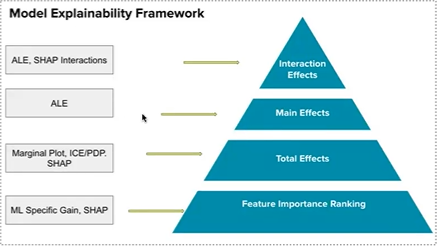

In [3]:
Image('explainability.png')

Interactions are crucial in data science because they help you capture non-linear and context-dependent relationships in your data. Ignoring interactions can lead to models that perform poorly and fail to represent the true underlying patterns in the data

## Import Library

In [3]:
!pip install pycebox --user

In [4]:
!pip install shap --user

In [5]:
! pip install PyALE --user

In [1]:
#! pip install xgboost==1.7.0 --user

In [7]:
! pip install xgboost --user

In [8]:
!pip install pyyaml==5.4.1 --user

In [1]:
#import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import itertools
import math
import yaml
import os
import pickle
from datetime import datetime
import shap
shap.initjs()
from PyALE import ale
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from matplotlib import pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import PartialDependenceDisplay #old version

In [3]:
driver = "DEFAULT"

In [4]:
root_path="POC_Model"
train_path = "POC_Model/Data"
test_path = "POC_Model/Data"
data_path="POC_Model/Data"
model_path_nv = "POC_Model/Model/mortgage.json"
output_dir = "POC_Model/Output"
fig_dir = "POC_Model/Output"
ins_df_path = "POC_Model/Data"
oot_df_pth = "POC_Model/Data"
explainer_pkl = os.path.join(output_dir, 'fitted_shap_explainer_5ct.pkl')
ins_df_pth = os.path.join(data_path, "df_ins.pkl")
oot_df_pth = os.path.join(data_path, "df_oot.pkl")

## Load Model Object


In [5]:
model_nv=  xgb.XGBClassifier()
model_nv.load_model(model_path_nv)

In [6]:
if hasattr(model_nv, 'get_booster'):
    booster = model_nv.get_booster()
    feature_names = booster.feature_names

print(feature_names)
len(feature_names)

['orig_rate', 'orig_upb', 'orig_val', 'orig_term', 'loan_age', 'oltv', 'ocltv', 'dti', 'cscore_b', 'cscore_c', 'cscore_min', 'mi_pct', '12M Change', '36M Change', '60M Change', 'unemp', 'bad_vintage', 'channel_B', 'channel_C', 'channel_R', 'purpose_C', 'purpose_P', 'purpose_R', 'prop_CO', 'prop_CP', 'prop_MH', 'prop_PU', 'prop_SF', 'no_units_1.0', 'no_units_2.0', 'occ_stat_I', 'occ_stat_P', 'occ_stat_S', 'mi_type_1.0', 'mi_type_2.0', 'mi_type_3.0', 'num_bo_1.0', 'num_bo_2.0', 'first_flag_N', 'first_flag_Y', 'relocation_mortgage_indicator_N', 'relocation_mortgage_indicator_Y', 'high_balance_loan_indicator_N', 'high_balance_loan_indicator_Y']


44

- model_nv loaded the my saved columns but I want to make sure and I added columns by manually

In [7]:
features_nv=['orig_rate',
 'orig_upb',
 'orig_val',
 'orig_term',
 'loan_age',
 'oltv',
 'ocltv',
 'dti',
 'cscore_b',
 'cscore_c',
 'cscore_min',
 'mi_pct',
 '12M Change',
 '36M Change',
 '60M Change',
 'unemp',
 'bad_vintage',          
 'channel_B',
 'channel_C',
 'channel_R',
 'purpose_C',
 'purpose_P',
 'purpose_R',
 'prop_CO',
 'prop_CP',
 'prop_MH',
 'prop_PU',
 'prop_SF',
 'no_units_1.0',
 'no_units_2.0',
 'occ_stat_I',
 'occ_stat_P',
 'occ_stat_S',
 'mi_type_1.0',
 'mi_type_2.0',
 'mi_type_3.0',
 'num_bo_1.0',
 'num_bo_2.0',
 'first_flag_N',
 'first_flag_Y',
 'relocation_mortgage_indicator_N',
 'relocation_mortgage_indicator_Y',
 'high_balance_loan_indicator_N',
 'high_balance_loan_indicator_Y',
           ]

## Data Importing and Processing

In [8]:
ds_ins=pd.read_pickle(ins_df_pth)

In [9]:
ds_oot=pd.read_pickle(oot_df_pth)

## **SHAP Values**

When we look at the feature importance that tells us how important each feature is to the prediction in general. What about individual predictions? Feature importance can not tell us if features tend to increase or decrease the prediction or if we have a classification problem it would not tell us how the features change the probability of a positive prediction.

 **The Shapley value** is based on the idea of considering all possible orderings of features and calculating their marginal contributions to each possible coalition.
    - Consider all possible permutations (orderings) of the features.
    - For each permutation, calculate the marginal contribution of each feature. The marginal contribution of a feature is the difference in the total value generated when that feature joins the coalition compared to when they are not in the coalition.
    - Average the marginal contributions for each features over all possible permutations.
    
    Shapley Value : expected marginal contribution (weighted average of a feature's contributions)
It shows us how each feature has contributes to that prediction. Specificly how the model features increase or decrease the prediction.

In [10]:
explainer_nv = shap.TreeExplainer(model_nv)
print(f"base value for the target driver (average prediction): {explainer_nv.expected_value}")

base value for the target driver (average prediction): [0.]


In [11]:
ds_ins[features_nv].shape

(151598, 44)

In [12]:
ds_oot[features_nv].shape

(41592, 44)

In [13]:
ds_ins[features_nv].shape, ds_oot[features_nv].shape

((151598, 44), (41592, 44))

In [14]:
shap_values_ins_nv =  explainer_nv.shap_values(ds_ins[features_nv], check_additivity = False  )
shap_values_oot_nv =  explainer_nv.shap_values(ds_oot[features_nv], check_additivity = False  )

In [18]:
ds_ins.shape, ds_oot.shape

((151598, 88), (41592, 88))

In [19]:
shap_values_ins_nv

array([[ 0.59283453, -0.06493065,  0.03881482, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.4465445 , -0.05186786, -0.00259955, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.69995725, -0.05749932, -0.00259955, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.34492624,  0.037795  ,  0.00433286, ...,  0.        ,
         0.        ,  0.        ],
       [-0.7497472 , -0.04515628,  0.00819645, ...,  0.        ,
         0.        ,  0.        ],
       [-0.34132895, -0.0632102 , -0.00319863, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [20]:
## merge shap values with the original dataframe and save the dataframe

for i, col in enumerate(features_nv):
    ds_ins[col+'_shap'] = shap_values_ins_nv[:,i]


for i, col in enumerate(features_nv):
    ds_oot[col+'_shap'] = shap_values_oot_nv[:,i]


-Keep in mind that SHAP values can be positive or negative, indicating the direction and magnitude of the feature's effect on the model's prediction. Positive SHAP values contribute to increasing the prediction, while negative values contribute to decreasing it. You can use these values to gain insights into which features are driving the model's predictions in each dataset.

In [21]:
ds_ins.head()

,orig_rate,orig_upb,orig_val,orig_term,loan_age,oltv,ocltv,dti,cscore_b,cscore_c,...,mi_type_2.0_shap,mi_type_3.0_shap,num_bo_1.0_shap,num_bo_2.0_shap,first_flag_N_shap,first_flag_Y_shap,relocation_mortgage_indicator_N_shap,relocation_mortgage_indicator_Y_shap,high_balance_loan_indicator_N_shap,high_balance_loan_indicator_Y_shap
0,0.901961,0.072222,0.060554,0.375000,0.304348,0.485429,0.479786,0.573770,0.754701,0.535976,...,0.0,0.0,-0.266260,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960784,0.281481,0.196802,1.000000,0.032609,0.652359,0.647862,0.688525,0.469746,0.462355,...,0.0,0.0,0.204294,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.921569,0.174074,0.122251,1.000000,0.309783,0.652359,0.647862,0.196721,0.773759,0.769399,...,0.0,0.0,0.290977,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.051852,0.037418,0.583333,0.717391,0.652359,0.647862,0.475410,0.747164,0.742396,...,0.0,0.0,0.282940,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.960784,0.085185,0.065353,1.000000,1.000000,0.565491,0.560297,1.000000,0.495357,0.488066,...,0.0,0.0,0.212634,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Create a df shap values**

DataFrames, sv_ins and sv_oot, where each column represents the SHAP values for a specific feature in the corresponding dataset (ds_ins or ds_oot).

In [22]:
sv_ins=pd.DataFrame()
for i, col in enumerate(features_nv):
    sv_ins[col] = ds_ins[col+'_shap']

sv_oot=pd.DataFrame()
for i, col in enumerate(features_nv):
    sv_oot[col] =ds_oot[col+'_shap']

In [23]:
shap_cols = [col for col in ds_ins.columns if '_shap' in col]

In [24]:
len(shap_cols)

44

In [25]:
shap_cols

['orig_rate_shap',
 'orig_upb_shap',
 'orig_val_shap',
 'orig_term_shap',
 'loan_age_shap',
 'oltv_shap',
 'ocltv_shap',
 'dti_shap',
 'cscore_b_shap',
 'cscore_c_shap',
 'cscore_min_shap',
 'mi_pct_shap',
 '12M Change_shap',
 '36M Change_shap',
 '60M Change_shap',
 'unemp_shap',
 'bad_vintage_shap',
 'channel_B_shap',
 'channel_C_shap',
 'channel_R_shap',
 'purpose_C_shap',
 'purpose_P_shap',
 'purpose_R_shap',
 'prop_CO_shap',
 'prop_CP_shap',
 'prop_MH_shap',
 'prop_PU_shap',
 'prop_SF_shap',
 'no_units_1.0_shap',
 'no_units_2.0_shap',
 'occ_stat_I_shap',
 'occ_stat_P_shap',
 'occ_stat_S_shap',
 'mi_type_1.0_shap',
 'mi_type_2.0_shap',
 'mi_type_3.0_shap',
 'num_bo_1.0_shap',
 'num_bo_2.0_shap',
 'first_flag_N_shap',
 'first_flag_Y_shap',
 'relocation_mortgage_indicator_N_shap',
 'relocation_mortgage_indicator_Y_shap',
 'high_balance_loan_indicator_N_shap',
 'high_balance_loan_indicator_Y_shap']

 ## SHAP Plots
 **Individual Predictions**

### Force Plot  
-  Force plot provides a visual representation of how individual features contribute to a specific prediction made by a machine learning model. Force plots are particularly useful for understanding the importance and direction of each feature's impact on a particular prediction.

In [26]:
plt.savefig(os.path.join(fig_dir, "shap importance _forceplot_ins.png"))
shap.plots.force(explainer_nv.expected_value, ds_ins[shap_cols].values[8750,:],feature_names=features_nv)

<Figure size 640x480 with 0 Axes>

- Longer bars indicate a more significant impact, and the direction (up or down) indicates whether the feature increases or decreases the prediction.

In [27]:
plt.savefig(os.path.join(fig_dir, "shap importance_forceplot1000 _ins.png"))
shap.force_plot(explainer_nv.expected_value, ds_ins[shap_cols].values[1000,:],feature_names=features_nv)

<Figure size 640x480 with 0 Axes>

In [28]:
plt.savefig(os.path.join(fig_dir, "shap importance_forceplot_first10 _ins.png"))
shap.plots.force(explainer_nv.expected_value, ds_ins[shap_cols].values[0:10,:],feature_names=features_nv)

<Figure size 640x480 with 0 Axes>

### Waterfall Plot  
-Waterfall plots provide a visual representation of the contributions of each feature to a model prediction. They are similar to force plots but are presented in a stacked waterfall style, making it easy to trace the flow of contributions

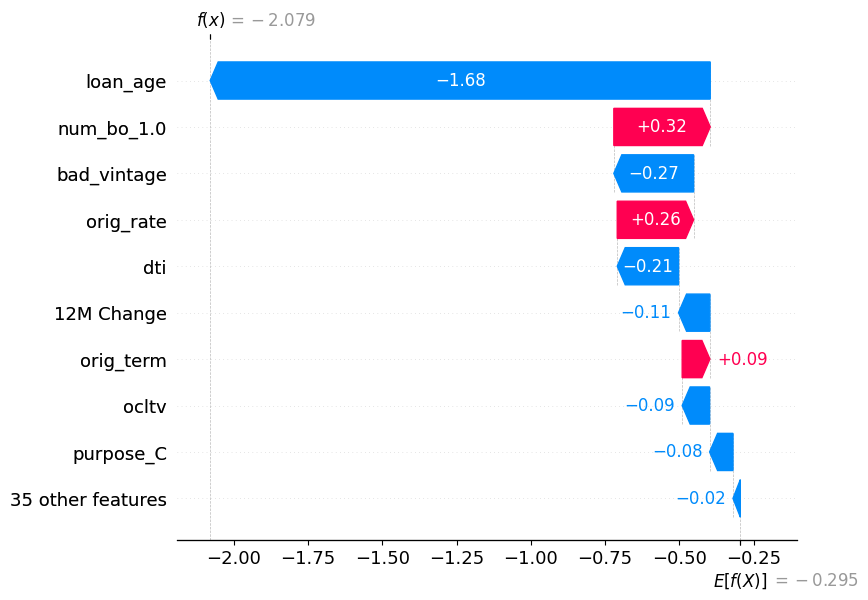

In [29]:
plt.savefig(os.path.join(fig_dir,'shap_waterfall_plot_100.png'))
exp = shap.Explanation(ds_ins[shap_cols].values[100], explainer_nv.expected_value, feature_names=features_nv)
shap.plots.waterfall(exp )

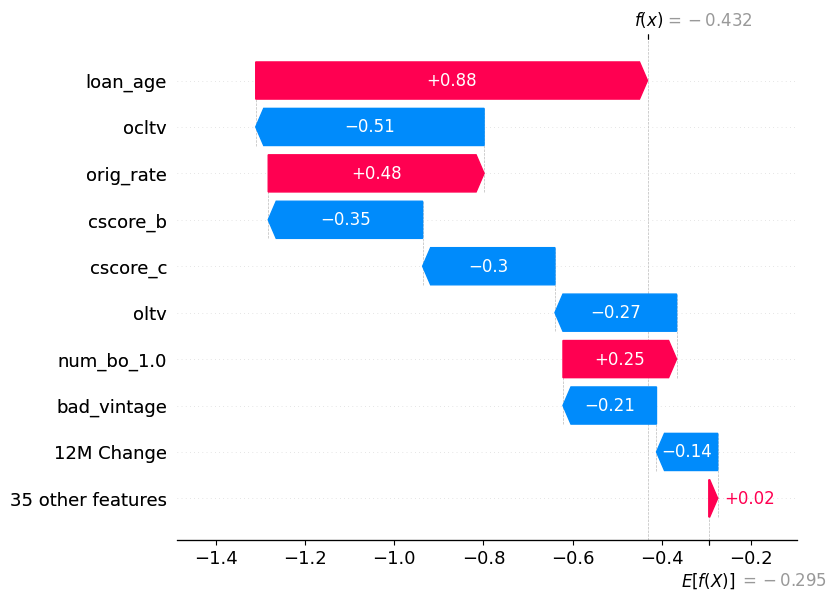

In [30]:
plt.savefig(os.path.join(fig_dir,'shap_waterfall_plot_1000.png'))
exp = shap.Explanation(ds_ins[shap_cols].values[1000], explainer_nv.expected_value, feature_names=features_nv)
shap.plots.waterfall(exp )

## **Feature Importances**

In [32]:
def get_imp_features(df, features, shap_values, n=10):
    
    vals = np.abs(shap_values).mean(0)
    feature_importance=pd.DataFrame(list(zip(df[features].columns, vals)),columns =['col_name', 'feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending =False, inplace= True)
    
    return list(feature_importance.head(n)['col_name']) 

In [33]:
ins_imp_features = get_imp_features(ds_ins[features_nv], features_nv, sv_ins, n=10)

oot_imp_features = get_imp_features(ds_oot[features_nv], features_nv, sv_oot, n=10)

In [34]:
ins_imp_features

['loan_age',
 'orig_rate',
 'cscore_b',
 'bad_vintage',
 'cscore_c',
 'num_bo_1.0',
 'ocltv',
 'dti',
 '60M Change',
 'orig_term']

In [35]:
oot_imp_features

['loan_age',
 'orig_rate',
 'cscore_b',
 'num_bo_1.0',
 'cscore_c',
 'ocltv',
 'bad_vintage',
 'dti',
 'orig_term',
 '60M Change']

### Bar Plot

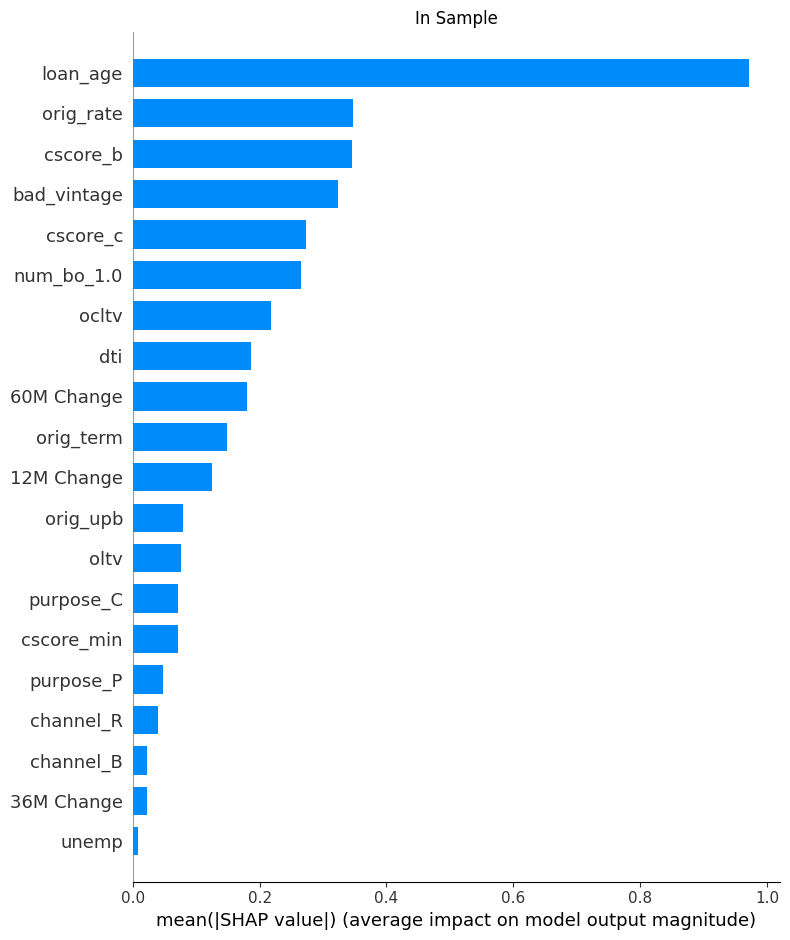

<Figure size 640x480 with 0 Axes>

In [36]:
# Important features of in-sample
plt.title('In Sample')
shap.summary_plot(ds_ins[ shap_cols].values, ds_ins[ features_nv], plot_type='bar', max_display=20,
                  feature_names=features_nv, show=True)
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'shap importance _ins.png'))

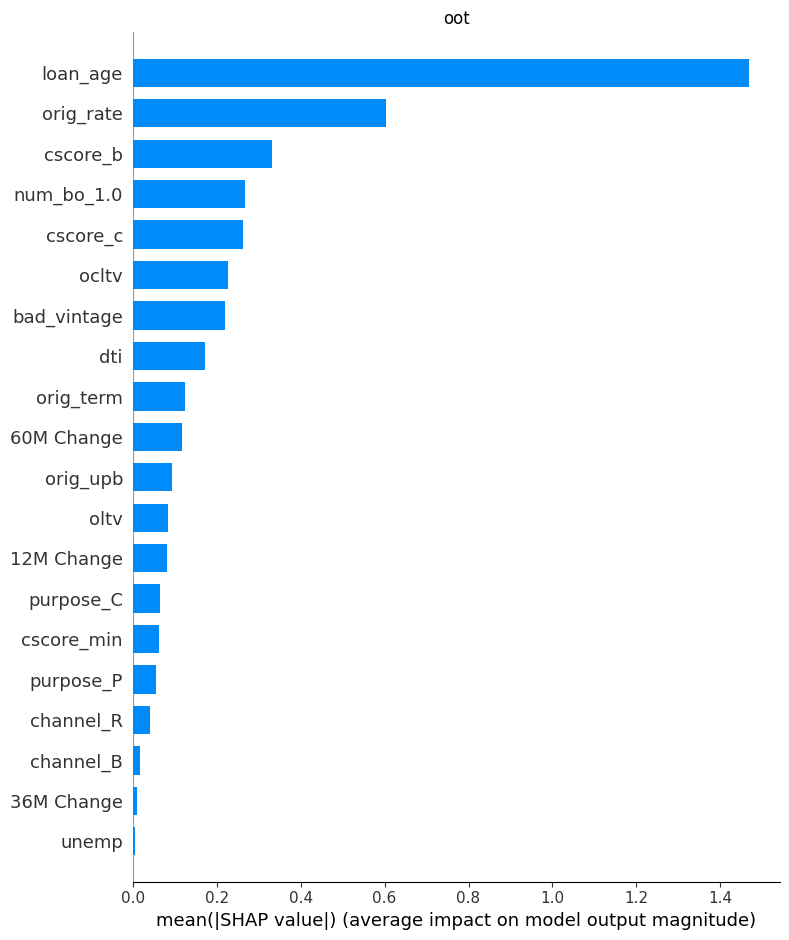

In [37]:
shap.summary_plot(ds_oot[shap_cols].values, ds_oot[features_nv], plot_type="bar", max_display=20,
                  feature_names=features_nv,show=False)
plt.title( 'oot')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'shap importance oot.png'))

### Total Gain   
-Total gain measures the total contribution of a feature to the model's predictions

In [38]:
def write_sorted_output(df, column_name, output):
    df.columns = [column_name]
    df.sort_values(by=column_name, ascending =False, inplace =True)
    df['% of sum'] =df[column_name] /df[column_name].sum()
    df.to_csv(output)

In [42]:
write_sorted_output(pd.DataFrame(sv_oot[oot_imp_features].abs().mean()), column_name= 'avg_abs_shap',
                                   output=os.path.join(output_dir, 'mean_SHAP_oot.csv'))

In [43]:
def feat_importance(model, feature_names, importance_type, output, column_name=None, ax=None, **kwargs):
    
    if not column_name:
        
        column_name = importance_type
    
    mod  = model if isinstance(model, xgb.Booster) else model.get_booster()

    gain = mod.get_score(importance_type=importance_type)

    write_sorted_output(pd.DataFrame.from_dict(gain, orient="index"), column_name=column_name,output=output)
    
    if not ax:
        fig, ax = plt.subplots (figsize=(10,10))
        ax.spines['top'].set_visible (False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        xgb.plot_importance(
          gain,
          ax=ax,
          importance_type=importance_type,
          max_num_features=20,
          title=kwargs.get('title', column_name),
          grid=False,
          ylabel=None,
          color=kwargs.get('color', 'maroon'))
        return ax


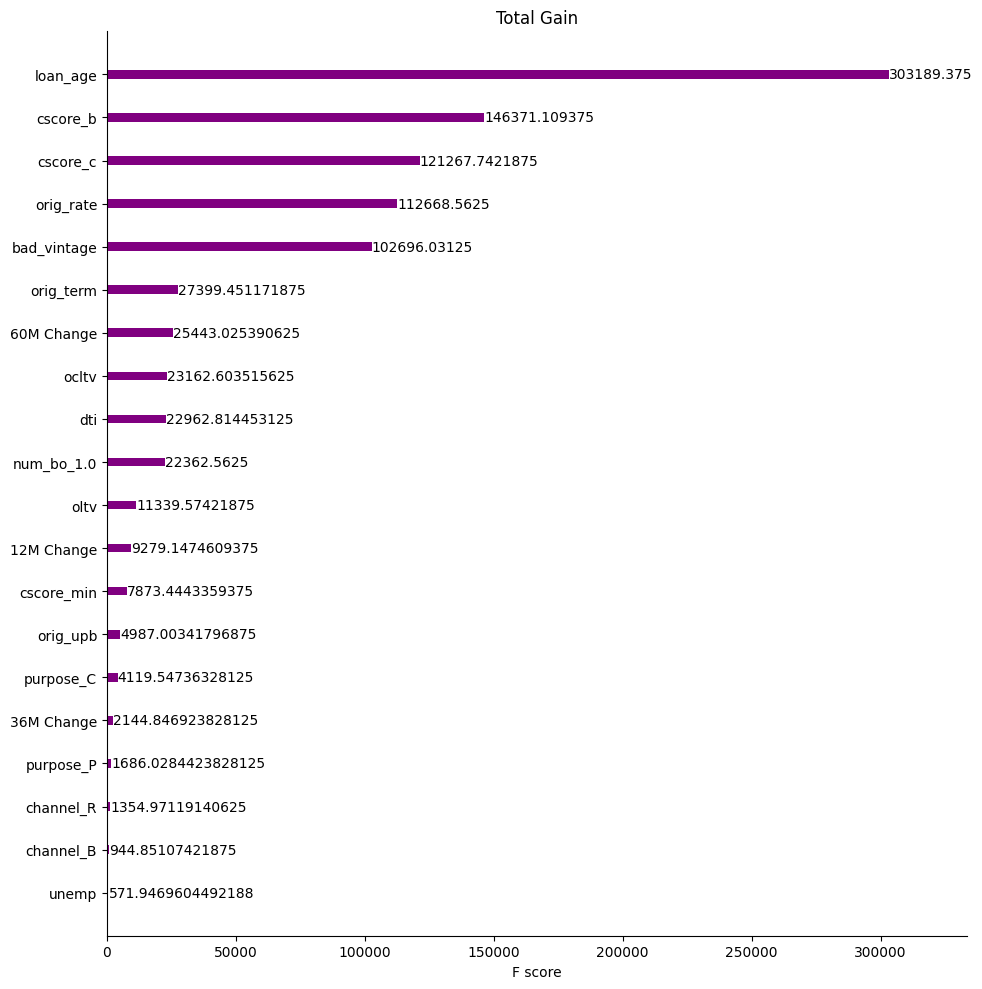

In [44]:
feat_importance(model_nv,features_nv,importance_type='total_gain', output=os.path.join(output_dir,'total_gain.csv'),
                        title='Total Gain',color='purple')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'feat_importance_total_gain_nv.png'))

### Avarage Gain   
- Average gain" can be more fair when comparing the importance of categorical features with different numbers of levels. It avoids overemphasizing features with more levels, which might not necessarily be more informative. Let's check the categorical columns' places


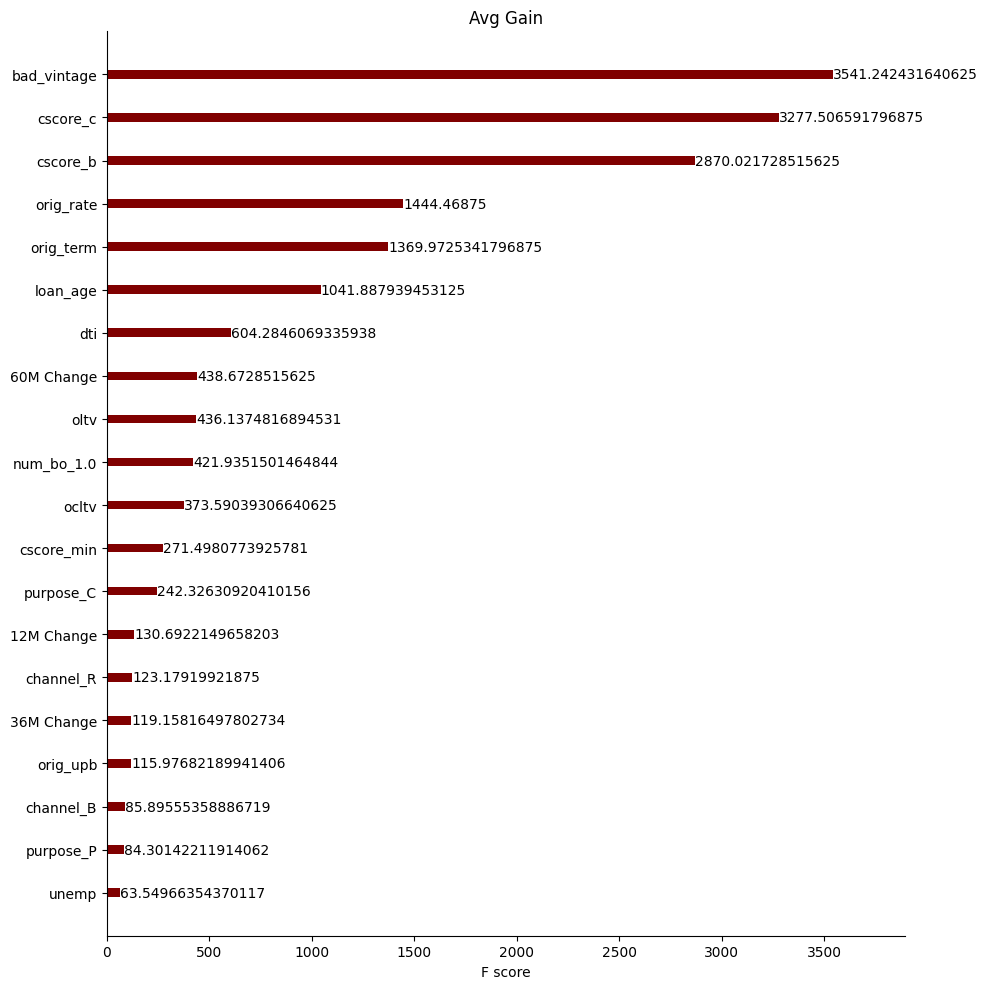

In [45]:
feat_importance(model_nv, features_nv, importance_type='gain', output=os.path.join(output_dir, 'avg gain.csv'),
                column_name='avg_gain',title='Avg Gain',color='maroon')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'feat_importance_avg_gain_nv.png'))

### Summary Plot

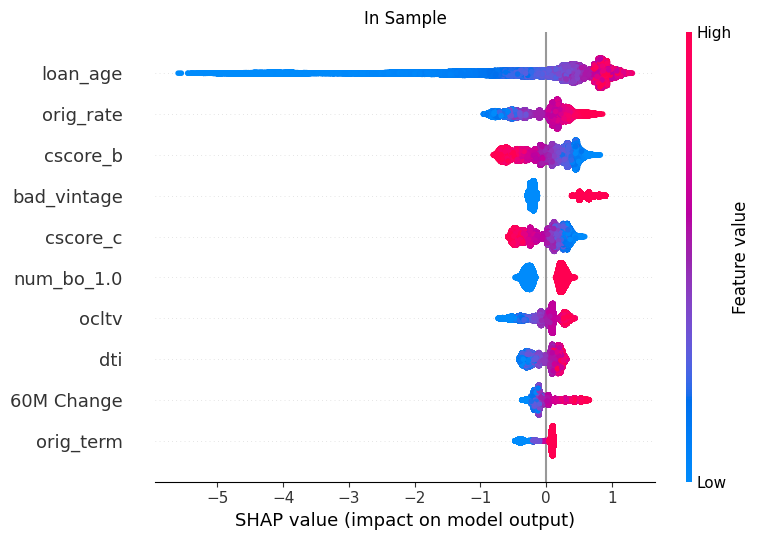

In [46]:
# Important features of in-sample
shap.summary_plot(ds_ins[shap_cols].values,ds_ins[features_nv], max_display=10, feature_names=features_nv, show=False)
plt.title('In Sample')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'shap_summary ins.png'))

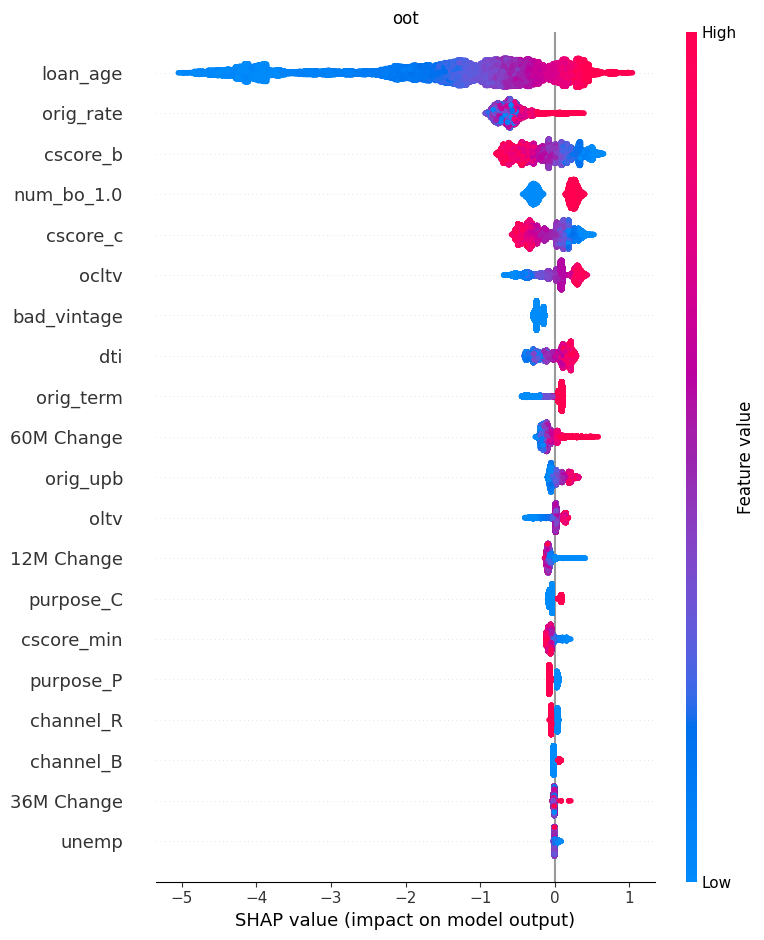

In [47]:
# Important features of in-sample
shap.summary_plot(ds_oot[shap_cols].values, ds_oot[features_nv], max_display=20, feature_names=features_nv, show=False)
plt.title('oot')
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, 'shap_summary oot.png'))

##  **Individual Feature Impact**

###  PDP and ICE 
- Partial Dependence Plot (PDP)   

PDP illustrates the relationship between a feature and the predicted outcome while holding all other features constant.
It helps us to understand the effect of a single feature on the model's predictions, and how this effect changes as the feature's value varies.
PDPs are typically created by fixing the values of the other features at some reasonable baseline or by sampling a range of values for the feature of interest.
- Individual Conditional Expectation (ICE) Plot:

ICE is a more granular approach compared to PDP. Instead of showing the average effect of a feature, ICE plots display the impact on predictions for each individual data point.

In [48]:
# Downsample further.
ds_ins_ice = ds_ins.sample(frac=0.05, random_state= 0)
ds_oot_ice = ds_oot.sample(frac=0.05, random_state= 0)

In [49]:
ds_ins_ice

,orig_rate,orig_upb,orig_val,orig_term,loan_age,oltv,ocltv,dti,cscore_b,cscore_c,...,mi_type_2.0_shap,mi_type_3.0_shap,num_bo_1.0_shap,num_bo_2.0_shap,first_flag_N_shap,first_flag_Y_shap,relocation_mortgage_indicator_N_shap,relocation_mortgage_indicator_Y_shap,high_balance_loan_indicator_N_shap,high_balance_loan_indicator_Y_shap
66600,0.666667,0.120370,0.074265,1.000000,0.445652,0.846930,0.844653,0.590164,0.911744,0.909864,...,0.0,0.0,0.288278,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30371,0.627451,0.362963,0.253357,1.000000,0.456522,0.652359,0.647862,0.606557,0.330741,0.323442,...,0.0,0.0,0.183753,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107546,0.725490,0.144444,0.121646,0.791667,0.581522,0.455286,0.449528,0.934426,0.527815,0.520697,...,0.0,0.0,0.222766,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114259,0.470588,0.274074,0.214226,1.000000,0.059783,0.516644,0.511152,0.311475,0.986416,0.986113,...,0.0,0.0,-0.451527,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13641,0.627451,0.174074,0.112925,0.375000,0.418478,0.765733,0.782543,0.704918,0.596660,0.590069,...,0.0,0.0,0.226061,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128153,0.176471,0.301852,0.290088,0.375000,0.331522,0.332700,0.326838,0.639344,0.849038,0.845958,...,0.0,0.0,0.276166,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116204,0.411765,0.501852,0.447221,1.000000,0.021739,0.384567,0.378672,0.475410,0.955198,1.000000,...,0.0,0.0,-0.328706,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92830,0.843137,0.337037,0.266645,1.000000,0.385870,0.500902,0.495330,1.000000,0.495357,0.577039,...,0.0,0.0,-0.213935,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3966,0.784314,0.061111,0.051741,1.000000,0.500000,0.485429,0.479786,0.311475,0.377921,0.351190,...,0.0,0.0,-0.259460,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
oot_imp_features

['loan_age',
 'orig_rate',
 'cscore_b',
 'num_bo_1.0',
 'cscore_c',
 'ocltv',
 'bad_vintage',
 'dti',
 'orig_term',
 '60M Change']

- get_mean_per_bin that calculates the mean of a specified variable within bins created from a given DataFrame. It is binning a numerical variable (grp_var) into discrete bins and calculating the mean of another variable (ret_var) within those bins. 

In [51]:
def get_mean_per_bin(df, grp_var, ret_var, nbins):
    ds_new=df.copy()
    ds_new[grp_var+"_group"], bins=pd.cut (ds_new[grp_var], nbins, labels=False, retbins=True,right=False)
    ds_new[grp_var +"_group"] += 1.0

    bin_midpoints = pd.DataFrame (pd.Series(bins).rolling(2).mean().iloc[1:])
    bin_midpoints.columns = [grp_var +"_midpt"]
    bin_midpoints[grp_var + "_group"]=list (range (1, nbins + 1))

    _df=ds_new.merge (bin_midpoints, left_on=grp_var + "_group", right_on=grp_var +"_group")

    return(
      _df[[grp_var +"_midpt", ret_var]].groupby (grp_var + "_midpt").mean()[ret_var])
### HH figure out what retbins did for your pd.cut

In [52]:
def plot_shap(f, df, driver, explainer, kind="bar", ax=None,**kwargs):
    
    if not ax:
        fig, ax =plt.subplots (figsize=kwargs.get ("figsize",(10,10)))

    _=ax.axhline(y=0, color="grey", linestyle="-", label=kwargs.get("hline_label", "Avg. Prediction={:.1f}".format (explainer.expected_value)))
    ax.scatter(df[f], df[f +"_shap"], label="SHAP values", s=kwargs.get("s", 10), color=kwargs.get("color", "blue"), alpha=kwargs.get ("alpha", 0.01))

    if kind == "bar":
        grp_plt = df[[f,f + "_shap"]].groupby(f).mean()[f + "_shap"]
        ax.bar(grp_plt.index, grp_plt, label="Avg. SHAP values", width=kwargs.get ("width",1), color=kwargs.get("color", "brown"))

    elif kind == "line":
        grp_plt = get_mean_per_bin(df, f, f + "_shap", nbins=kwargs.get ("nbins", 10))
        ax.plot(grp_plt, label="Avg. SHAP values", color=kwargs.get("color", "brown"))

    else:
        raise Exception(f"{kind} not recognized. Should be one of['bar',line]")

    ax.set_xlabel(f)
    ax.set_ylabel("Impact on "+ driver + "\n(deviation from | avg. pred)")

    # set full alpha for scatter plot marker in legend.

    leg = ax.legend ()
    for lh in leg.legendHandles:
        lh.set_alpha (1)
    return ax

In [53]:
def plot_shap_test_train(ins_df, oot_df, explainer, nbins=10, kind='line', **kwargs):
    fig, axes = plt.subplots(2, sharex=True, figsize=(6,8))

    plot_shap(f, ins_df, driver, nbins=nbins, explainer=explainer, ax=axes[0], alpha=0.05, kind=kind, **kwargs)
    
    plot_shap(f, oot_df, driver, nbins=nbins, explainer=explainer, ax=axes[1], alpha=0.05, kind=kind, **kwargs)
    
    _ = axes[0].set_title('In Sample')
    _ = axes[1].set_title('Out of Sample')
    
    plt.tight_layout()
    if kwargs.get('output'):
        plt.savefig(kwargs.get('output'))

CPU times: total: 1.08 s
Wall time: 3.55 s


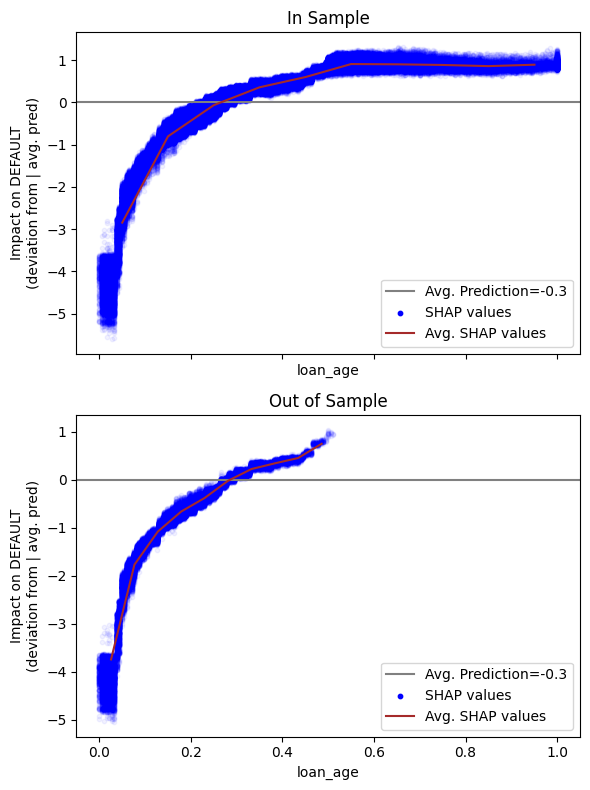

In [54]:
%%time
f='loan_age'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line', 
                     output=os.path.join(fig_dir, 'shap_v_{}.png'.format(f)))

CPU times: total: 297 ms
Wall time: 2.58 s


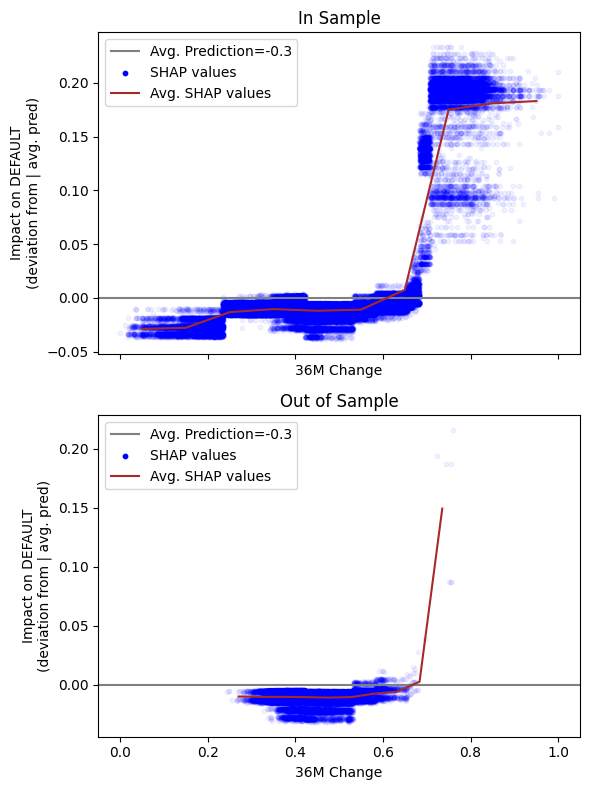

In [55]:
%%time
f= '36M Change'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                    output=os.path.join(fig_dir, 'shap_nv_{}.png'.format(f)))

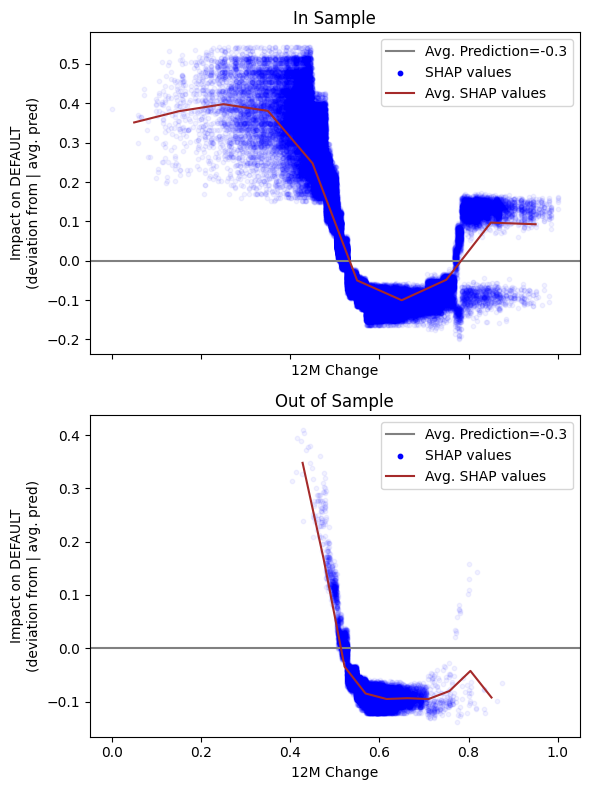

In [56]:
f= '12M Change'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                    output=os.path.join(fig_dir, 'shap_nv_{}.png'.format(f)))

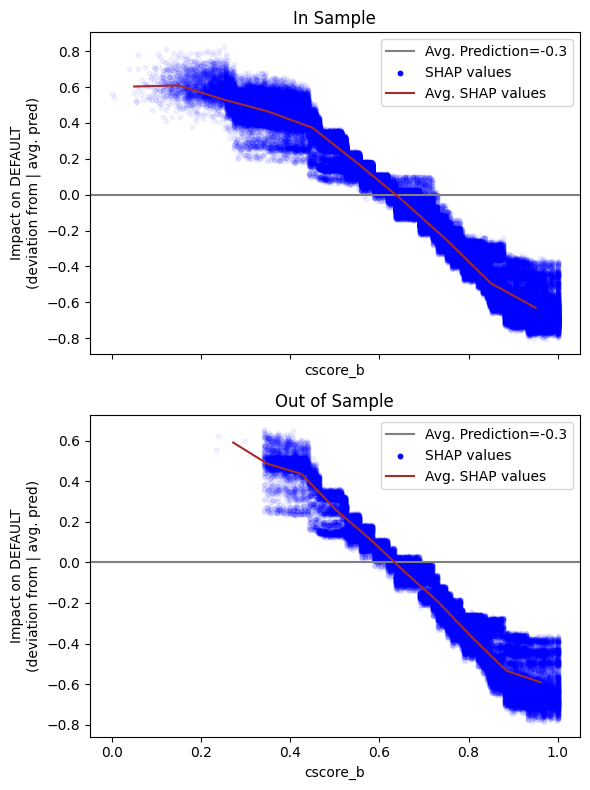

In [57]:
f= 'cscore_b'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                    output=os.path.join(fig_dir, 'shap_nv_{}.png'.format(f)))

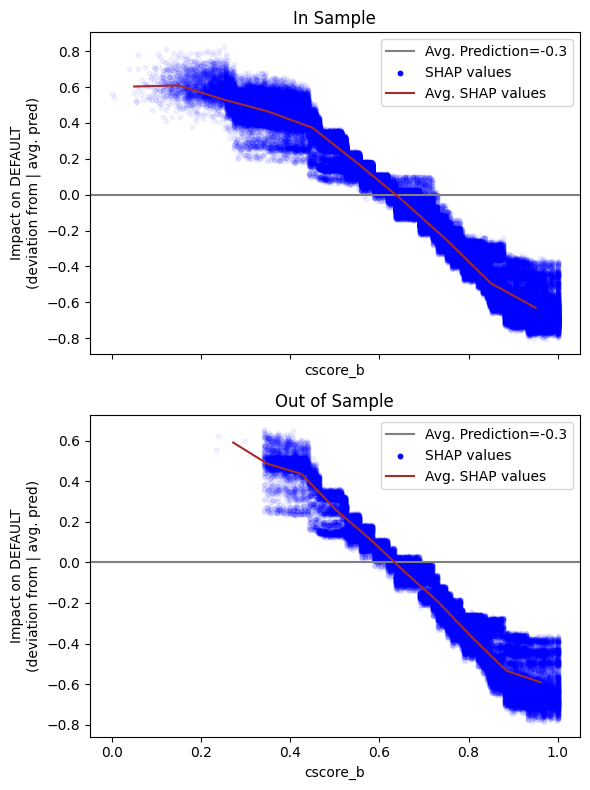

In [58]:
f='cscore_b'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                    output=os.path.join(fig_dir, 'shap_{}.png'.format(f)))

CPU times: total: 1.16 s
Wall time: 2.67 s


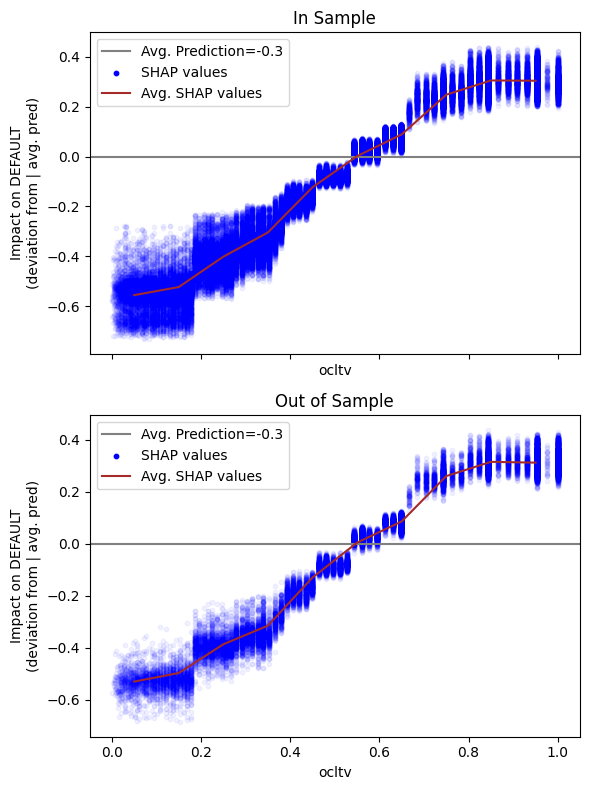

In [59]:
%%time
f='ocltv'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                     output=os.path.join(fig_dir, 'shap_{}.png' .format(f)))

CPU times: total: 922 ms
Wall time: 2.05 s


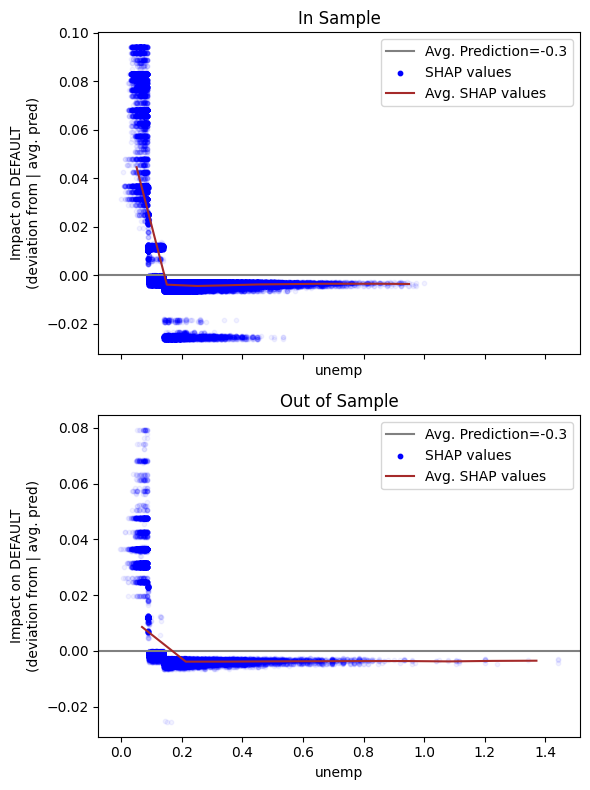

In [60]:
%%time
f='unemp'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='line',
                     output=os.path.join(fig_dir, 'shap_{}.png' .format(f)))

**Categorical Features Shap values**

CPU times: total: 438 ms
Wall time: 2.15 s


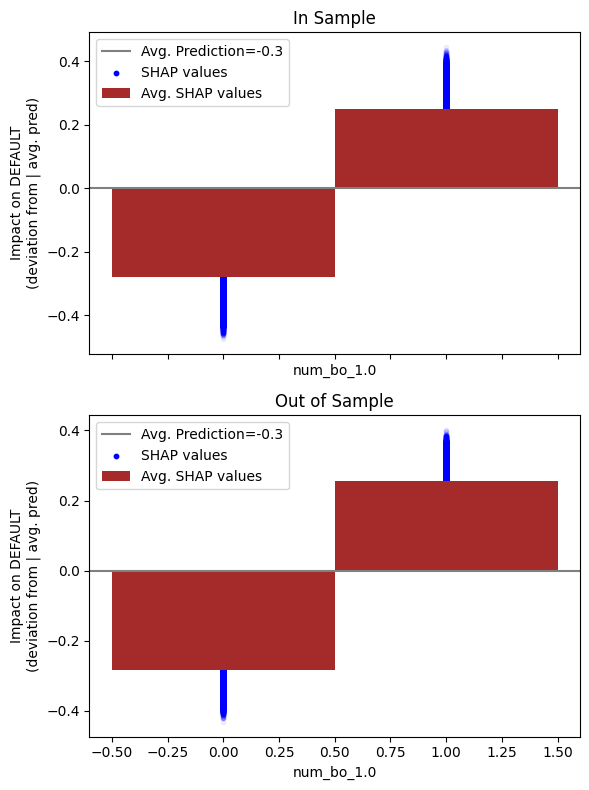

In [61]:
%%time
f='num_bo_1.0'
plot_shap_test_train(ds_ins, ds_oot, explainer_nv, nbins=10, kind='bar',
                    output=os.path.join(fig_dir, 'shap_{}.png'.format(f)))

### ALE Plot 
- ALE (Accumulated Local Effects) plots, sometimes referred to as "partial dependence plots," are a type of visualization used to understand the effect of specific features on a machine learning model's predictions. They illustrate how changes in a single feature's value influence the model's predictions while keeping all other features constant. ALE plots are valuable for interpreting the behavior of complex models, especially for the top influential features.

In [62]:
def ale_compare_test_train(ds_ins, ds_oot, f, predictor, driver, explainer, features, n_bins=10,x_grid_points=None,
                           feature_type='Cont', **kwargs):

    if feature_type!='Discrete':
        ale_eff = ale(X=ds_ins[features], model=predictor, feature=[f],include_CI=False, C=0.95)#the confidence level to 95% for any statistical analysis.
        ale_eff = ale(X=ds_oot[features], model=predictor, feature=[f],include_CI=False, C=0.95)
        
    else:
        ale_discr = ale(ds_ins[features],model=predictor, feature=[f],feature_type="discrete")
        ale_discr = ale(ds_oot[features],model=predictor, feature=[f],feature_type="discrete")
        
    if kwargs.get('output'):
              plt.savefig(kwargs.get('output'))

PyALE._ALE_generic:INFO: Discrete feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


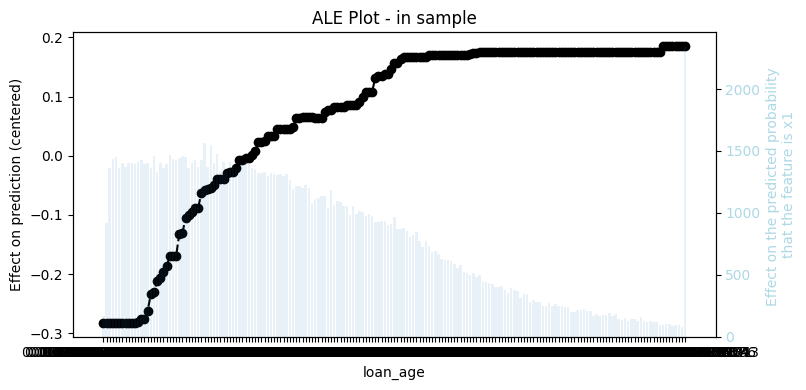

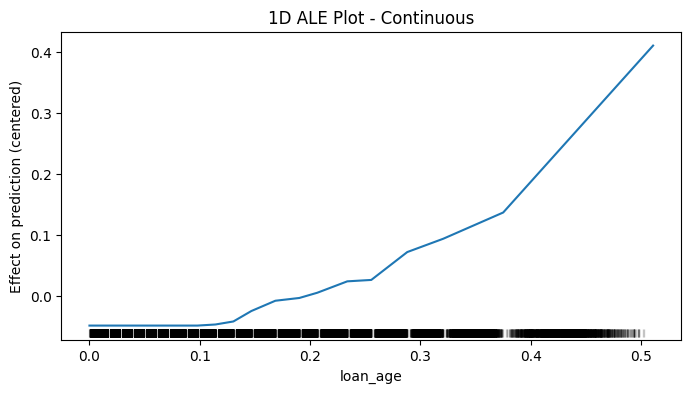

In [63]:
dmatrix=xgb.DMatrix(ds_ins[features_nv])
model_nv.predict(ds_ins[features_nv])

ale_eff = ale(X=ds_ins[features_nv], model=model_nv, feature=['loan_age'], include_CI=False, C=0.95)
plt.ylabel('Effect on the predicted probability \nthat the feature is x1')
plt.title('ALE Plot - in sample')
ale_eff = ale(X=ds_oot[features_nv], model=model_nv, feature=['loan_age'], include_CI=False, C=0.95)

In [ ]:
f = 'unemp'
mod = model_nv
ale_compare_test_train(ds_ins,
                        ds_oot,
                        f,
                        mod,
                        driver,
                        explainer_nv,
                        features_nv,
                        x_grid_points=None,
                        output=os.path.join(fig_dir, 'shap {}.png'.format(f)))

PyALE._ALE_generic:INFO: Continuous feature detected.
PyALE._ALE_generic:INFO: Continuous feature detected.


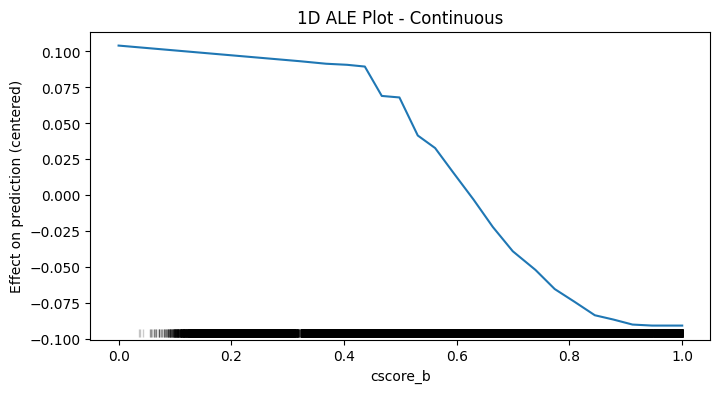

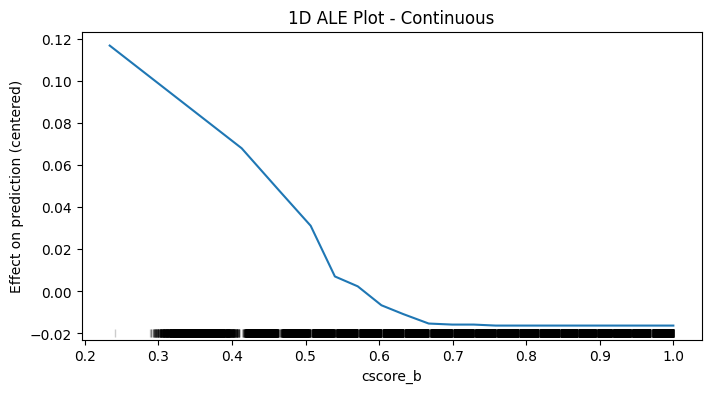

In [64]:
f='cscore_b'
mod = model_nv
ale_compare_test_train(ds_ins, ds_oot, f, mod, driver, explainer_nv, features_nv, x_grid_points=None,
                        output=os.path.join(fig_dir, 'shap {}.png'.format(f)))

**Read ins_df_path**

In [66]:
ds=pd.read_pickle(ins_df_pth)

In [67]:
ds[features_nv].shape

(151598, 44)

In [68]:
model_nv.feature_importances_.shape

(44,)

### Feature Importances

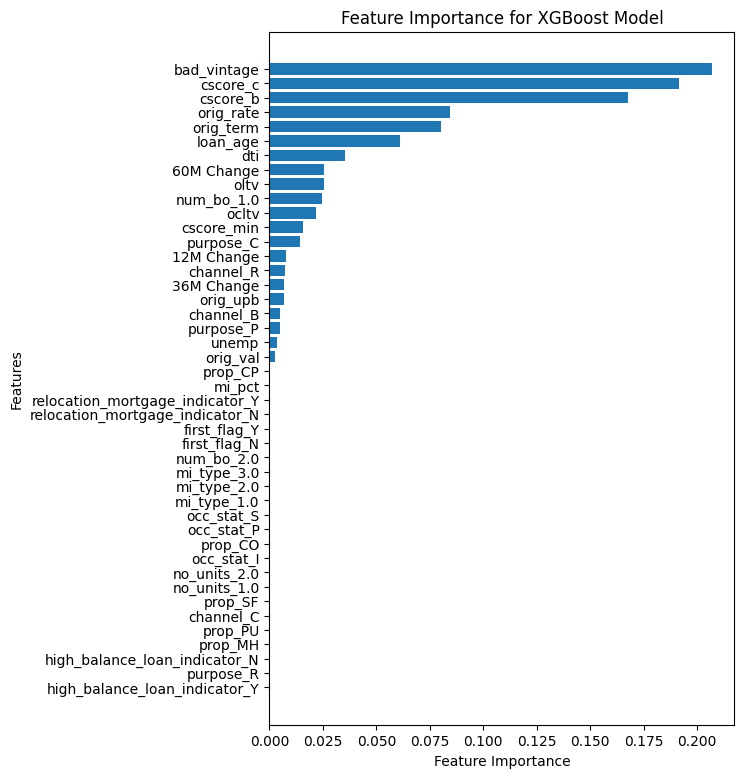

In [73]:
importances = model_nv.feature_importances_
feature_names = ds[features_nv].columns

sorted_indices = np.argsort(importances)
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

plt.figure(figsize=(6, 9))
plt.barh(range(len(sorted_feature_names)), sorted_importances)
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGBoost Model');

In [70]:
import sklearn
print(sklearn.__version__)

1.3.1


In [71]:
#!pip install scikit-learn==1.3.1 --user

### Partial Dependence of Two Features 

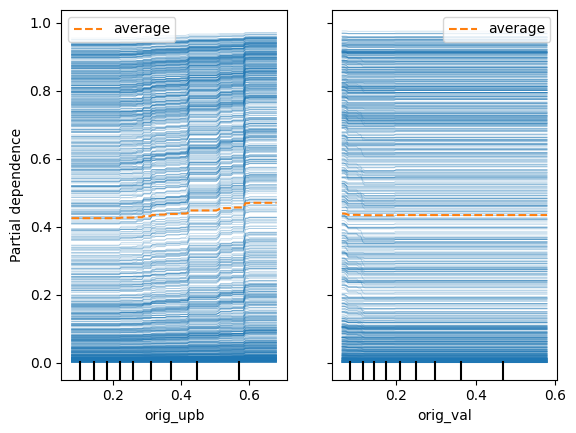

In [72]:
#from sklearn.inspehttp://localhost:8891/notebooks/JupyterNotes/Group_Project/Mortgage_Default_Project_Explainability_BetulOzkaldi.ipynb#Partial-Dependence-of-Two-Featuresction._partial_dependence import  partial_dependence
from sklearn.inspection import PartialDependenceDisplay
 
    
deciles = {0: np.linspace(0, 1, num=5)}
features, feature_names = [(0,)], features_nv

PartialDependenceDisplay.from_estimator( model_nv, ds[features_nv], [1, 2],kind='both')

##  **Feature Interactions**

In [148]:
!pip list

Package                           Version
--------------------------------- --------
absl-py                           1.4.0
aiofiles                          22.1.0
aiosqlite                         0.18.0
alabaster                         0.7.13
annotated-types                   0.5.0
anyio                             3.5.0
appdirs                           1.4.4
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
asttokens                         2.0.5
astunparse                        1.6.3
atomicwrites                      1.4.1
attrs                             22.1.0
Babel                             2.11.0
backcall                          0.2.0
beautifulsoup4                    4.12.2
bleach                            4.1.0
blis                              0.7.10
boto3                             1.28.40
botocore                          1.31.40
bounded-pool-executor             0.0.3
branca                            0.6.0
brotlipy              


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [153]:
!pip install pdpbox --user


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
ins_imp_features[:7]

['loan_age',
 'orig_rate',
 'cscore_b',
 'bad_vintage',
 'cscore_c',
 'num_bo_1.0',
 'ocltv']

In [93]:
feats=ins_imp_features
feats

['loan_age',
 'orig_rate',
 'cscore_b',
 'bad_vintage',
 'cscore_c',
 'num_bo_1.0',
 'ocltv',
 'dti',
 '60M Change',
 'orig_term']

###  Two-way SHAP dependence plot 

In [99]:
def plot_dependence(ds_ins, ds_oot, feat, interaction_feat, features, alpha=0.6, **kwargs):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6,10))
    axes[1].set_title("Out of Time")
    axes[0].set_title("In Time")
    output = kwargs.pop( 'output' )
    shap.dependence_plot(feat, shap_values=ds_ins[shap_cols].values, features=ds_ins[features].values,
                feature_names=features, interaction_index=interaction_feat, alpha=alpha, ax=axes[0], show=False,**kwargs)
    
    shap.dependence_plot(feat, shap_values=ds_oot[shap_cols].values, features=ds_oot[features].values ,
        feature_names=features, interaction_index=interaction_feat, alpha=alpha, ax=axes[1], **kwargs)
    
    if output:
        plt.savefig(output)

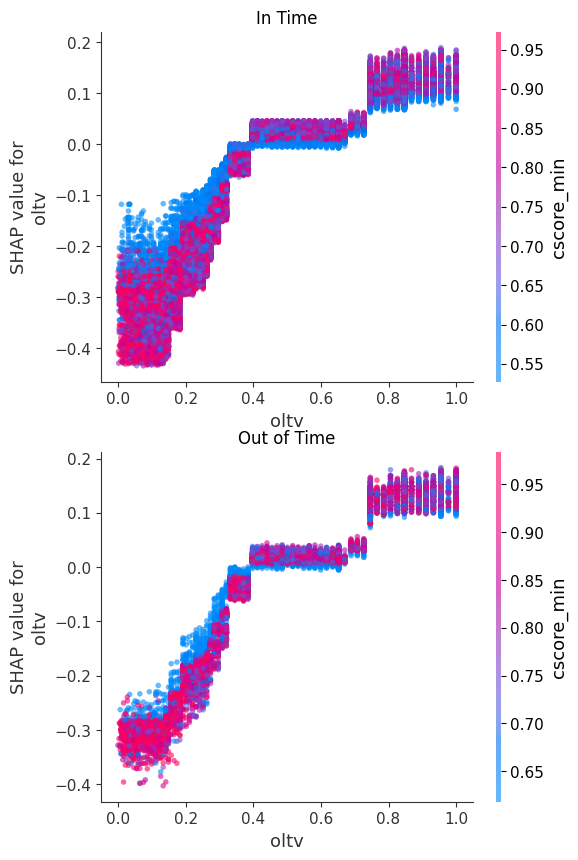

<Figure size 640x480 with 0 Axes>

In [100]:
f = 'oltv'
plot_dependence(ds_ins, ds_oot, feat=f, interaction_feat='cscore_min', features=features_nv,
                output=os.path.join(fig_dir, 'shap dependence {}.png'.format(f)))

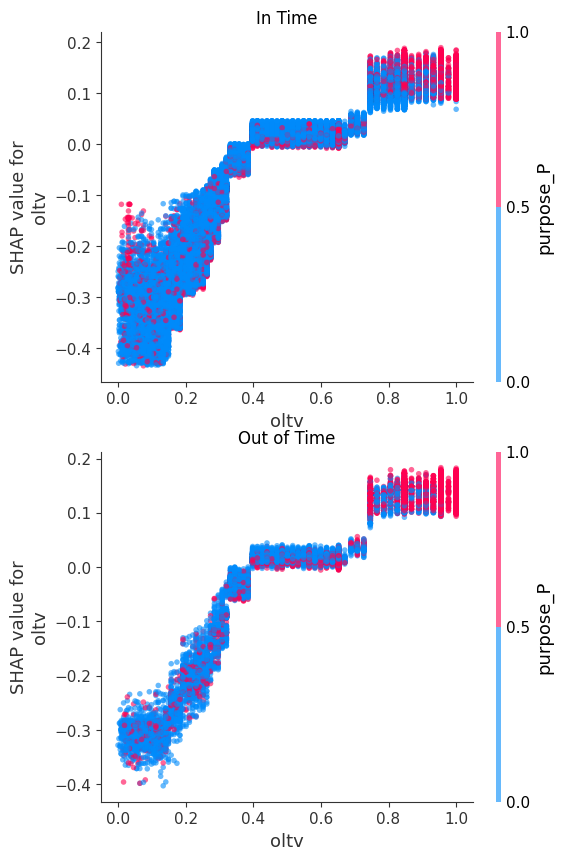

<Figure size 640x480 with 0 Axes>

In [106]:
f='oltv'
plot_dependence(ds_ins, ds_oot, feat=f, interaction_feat='purpose_P', features=features_nv,
                output=os.path.join(fig_dir, 'shap_dependence_{}.png'.format(f)))

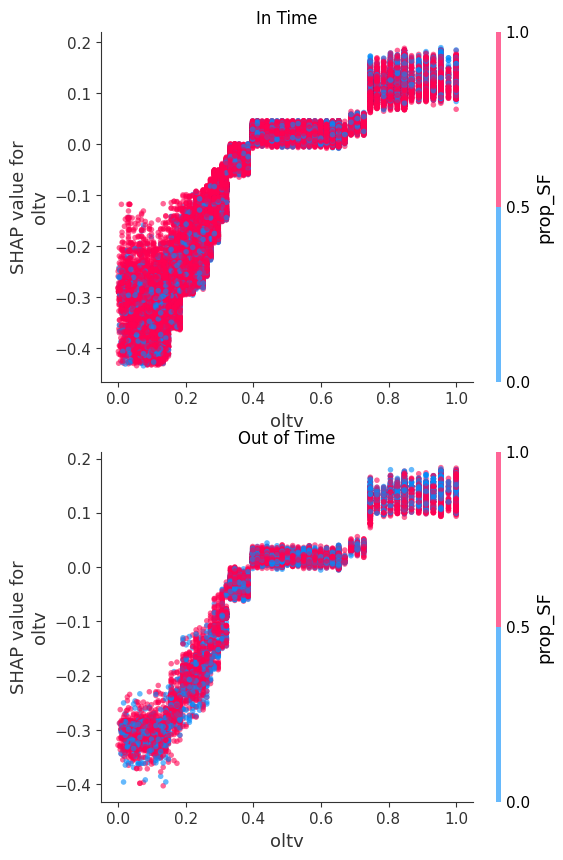

<Figure size 640x480 with 0 Axes>

In [107]:
f='oltv'
plot_dependence(ds_ins, ds_oot, feat=f, interaction_feat='prop_SF', features=features_nv,
                output=os.path.join(fig_dir, 'shap_dependence_{}.png'.format(f)))

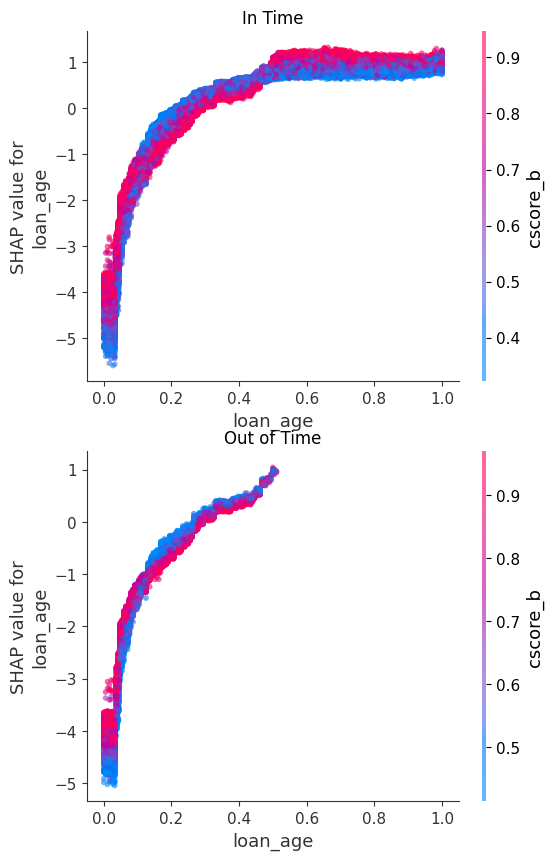

<Figure size 640x480 with 0 Axes>

In [108]:
f='loan_age'
plot_dependence(ds_ins, ds_oot, feat=f, interaction_feat='cscore_b', features=features_nv,
                output=os.path.join(fig_dir, 'shap_dependence_{}.png'.format(f)))

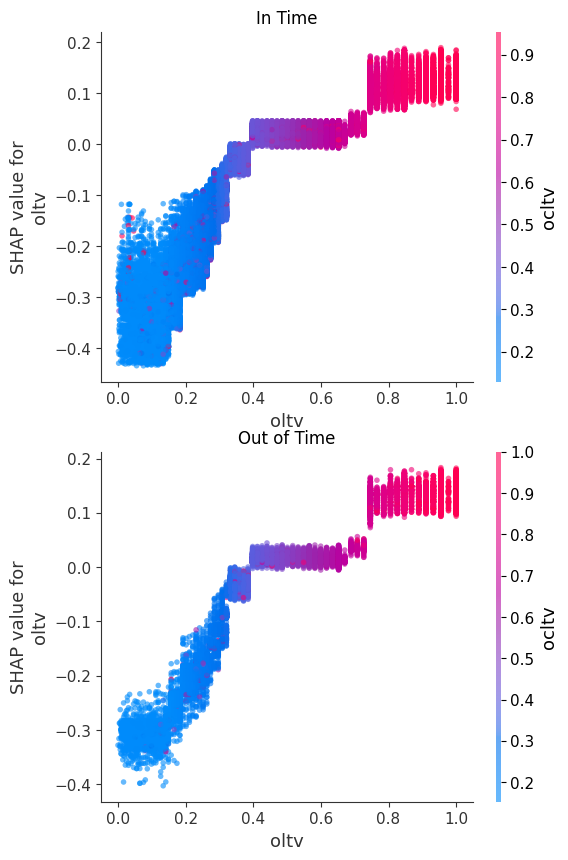

<Figure size 640x480 with 0 Axes>

In [112]:
f='oltv'
plot_dependence(ds_ins, ds_oot, feat=f, interaction_feat='ocltv', features=features_nv,
                output=os.path.join(fig_dir, 'shap_dependence_{}.png'.format(f)))

### Two-way ALE 

In [109]:
mod = model_nv
for i in range(len(top_h_ins)):
    try:
        vars=top_h_ins[i].rsplit(sep=' * ', maxsplit=- 1)
        if len(vars)>2:
            continue
            
        var1, var2 = vars[0], vars[1]
        plt.figure(figsize=(3,4))
        ale_eff = ale(X=ds_ins_v[features_v], model=model_v, feature=[var1, var2],grid_size=20,plot=True)

    except:
        pass
        #plt.savefig(os.path.join(fig_dir, 'two_way ale {}_ {}.png'.format(varl, var2)))

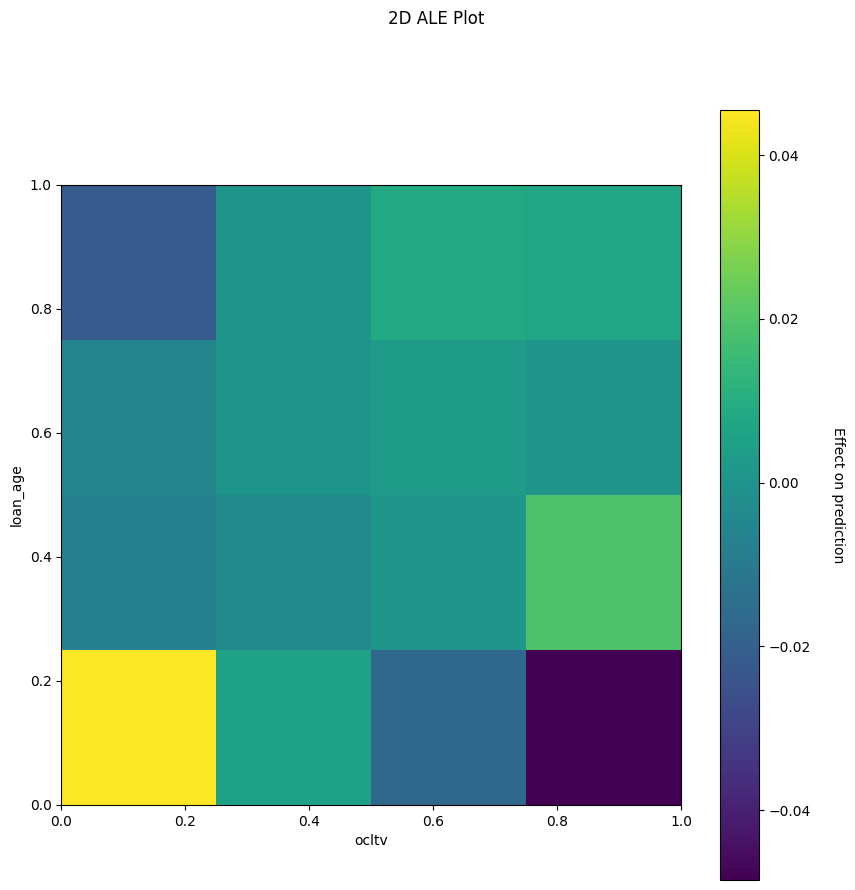

In [110]:
fig, ax = plt.subplots(figsize=(10, 10))
ale_eff = ale(X=ds_ins[features_nv], model=model_nv, feature=[ "loan_age",'ocltv'],grid_size=3,ax=ax,fig=fig)